In [1]:
import numpy as np 
import argparse 
import time
import einops 
import scipy.io as scio 
import matplotlib.pyplot as plt

In [3]:
masks_dir = "./test_datasets/mask"

# Open random_mask.mat
mask_dict = scio.loadmat(f"{masks_dir}/random_mask.mat")
mask = np.array(mask_dict["mask"], dtype=np.float32)
print(mask.shape)

(256, 256, 8)


In [52]:
# Load first_mask.bmp
f_mask = plt.imread(f"./second_mask.bmp")
f_mask = f_mask[:,:,0]
f_mask = np.array(f_mask, dtype=np.float32)
f_mask = np.reshape(f_mask, (4, 256, 256))
print(f_mask.shape)

(4, 256, 256)


In [53]:
# Save f_mask like {mask_dict}
# (f, h, w) -> (h, w, f)
to_save = np.transpose(f_mask, (1, 2, 0))

# 0 or 1
to_save = to_save // 255
# Integer
to_save = np.array(to_save, dtype=np.uint8)
scio.savemat(f"{masks_dir}/2x2_mask.mat", {"mask": to_save})

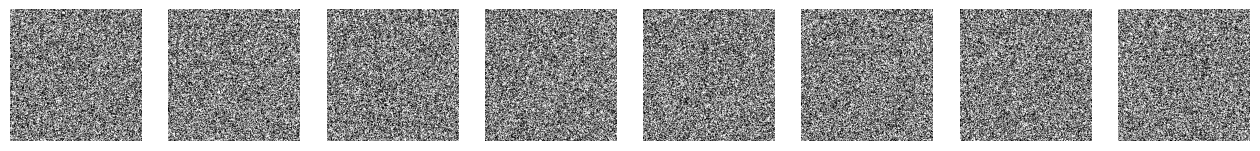

In [5]:
# 256 x 256 x 8
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axs[i].imshow(mask[:, :, i], cmap="gray")
    axs[i].axis("off")
plt.show()

In [50]:
sim_dir = "./test_datasets/simulation"

# Open kobe_cacti.mat
kobe_cacti = scio.loadmat(f"{sim_dir}/drop8_cacti.mat")
kobe_mask = kobe_cacti["mask"]
kobe_meas = kobe_cacti["meas"]
kobe_orig = kobe_cacti["orig"]

In [51]:
print(kobe_mask.shape)
print(kobe_meas.shape)
print(kobe_orig.shape)

(256, 256, 8)
(256, 256, 5)
(256, 256, 8)


In [58]:
vid_dir = "./test_datasets/simulation/00001"
# Consists of frame_00000.png, ..., frame_00015.png
import cv2
frames = []
for i in range(16):
    # Read image grayscale, resize to 256 x 256
    frame = cv2.imread(f"{vid_dir}/frame_{str(i).zfill(5)}.png", cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, (256, 256))
    frames.append(frame)
frames = np.array(frames)
print(frames.shape)

(16, 256, 256)


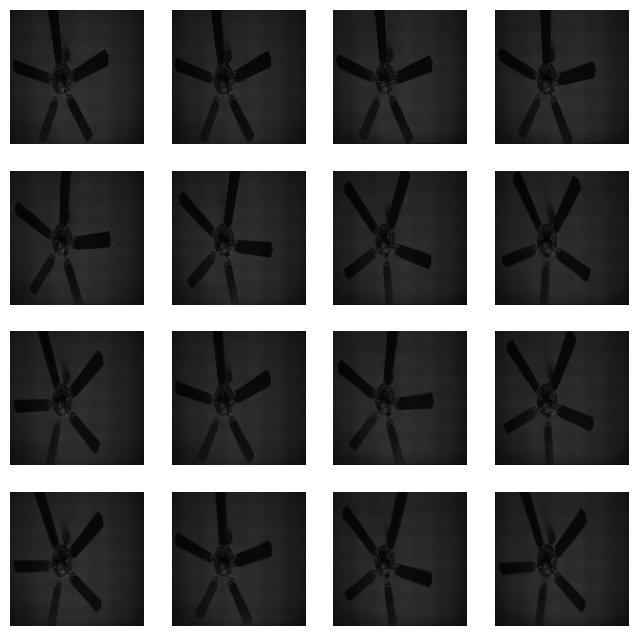

In [ ]:
# Plot the frames
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(frames[i*4+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

In [64]:
# Transpose then save as .mat
orig = np.transpose(frames, (1, 2, 0))
mask = np.tile(to_save, (1, 1, 4))
print(mask.shape)
meas = orig * mask

(256, 256, 16)


In [68]:
scio.savemat(f"{sim_dir}/fan.mat", {"mask": mask, "meas": meas, "orig": orig})

In [1]:
from cacti.utils.mask import generate_masks
from cacti.datasets.builder import build_dataset 
from cacti.utils.config import Config
from torch.utils.data import DataLoader

cfg = Config.fromfile("configs/STFormer/stformer_base.py")

mask,mask_s = generate_masks(cfg.train_data.mask_path,cfg.train_data.mask_shape)
train_data = build_dataset(cfg.train_data,{"mask":mask})
test_data = build_dataset(cfg.test_data,{"mask":mask})

train_data_loader = DataLoader(dataset=train_data, 
                                batch_size=cfg.data.samples_per_gpu,
                                shuffle=True,
                                num_workers = cfg.data.workers_per_gpu)

/scratch/ondemand28/dsaragih/envs/coded-sensors/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
shape = next(iter(train_data_loader))[0].shape
shape

torch.Size([1, 4, 128, 128])